In [1]:
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:

data_csv =  sorted(str(p) for p in pathlib.Path("C:\\Users\\Oleg\Desktop\\Paris_Saclay\\These\\4_DATA\\data_exp_2_pf\\0_data_raw").glob("*.csv"))
print(len(data_csv))


17


In [4]:
import csv

def detect_delimiter(csv_file):
    with open(csv_file, 'r') as file:
        dialect = csv.Sniffer().sniff(file.readline())
    return dialect.delimiter

def data_list(data_csv):
    data_l = []
    for elem in data_csv:
        delimiter = detect_delimiter(elem)
        data = pd.read_csv(elem, header=0, sep=delimiter)
        df_new = data.drop(columns=[
            'dot_mvt_start_time', 'last_dot_time', 'fix_start_time', 
            'button_pressed_time', 'end_time', 'start_exp_time', 'time_from_start [ces]'
        ])
        df_new['prop_left'] = df_new['response'].apply(lambda x: 0 if x == 1 else 1)
        df_new['acc'] = df_new.apply(lambda row: 1 if np.sign(row['response']) == np.sign(row['slope']) else 0, axis=1)
        df_new['RT'] = df_new['RT'].apply(lambda x: x / 1000) 

        df_new['direction'] = 'undefined'
        for noise_lvl, group in df_new.groupby('noise_lvl'):
            group_size = len(group)
            if group_size >= 40:
                group.iloc[:20, group.columns.get_loc('direction')] = 'right'
                group.iloc[20:40, group.columns.get_loc('direction')] = 'left'
            df_new.loc[group.index, 'direction'] = group['direction']
        
        data_l.append(df_new)
    return data_l

In [5]:
data_l_clean = data_list(data_csv)

In [6]:

def plot_staircase(data_list):
    for elem in range(len(data_list)):
        data= data_list[elem]
            
        unique_noise_levels = data['noise_lvl'].unique()
        fig, axes = plt.subplots(1, 4, figsize=(17, 4))  # Adjust the figsize as needed
        plt.suptitle(f"S {elem}",fontsize=15)
        data_grouped = data.groupby('noise_lvl')
        # Define a threshold value for distinguishing the two sets of data
        threshold = 20
        for i, (noise, group) in enumerate(data_grouped):
            slope_values = group['slope']
            prop_left_values = group['prop_left']
            # Separate the data into two sets based on the threshold
            slope_values_start = slope_values.iloc[:threshold]
            slope_values_other = slope_values.iloc[threshold:] 
            # Select the appropriate subplot
            ax = axes[i]
            ax.plot(slope_values_start, 'o-', color='k',   linewidth=1.5, markersize=4, )
            ax.plot(slope_values_other, 'o-', color='k',   linewidth=1.5, markersize=4, )
            ax.axhline(y=0, color='k', linestyle='--')
            ax.set_title(f'Staircase for Noise lvl {noise}', fontsize=14)
            ax.set_xlabel('Trial', fontsize=15)
            ax.set_ylabel('Slope', fontsize=15)
            ax.grid(True, linestyle='--', alpha=0.6)        
    # Adjust the spacing between subplots
        plt.tight_layout()
        # Display the plot
        plt.show()

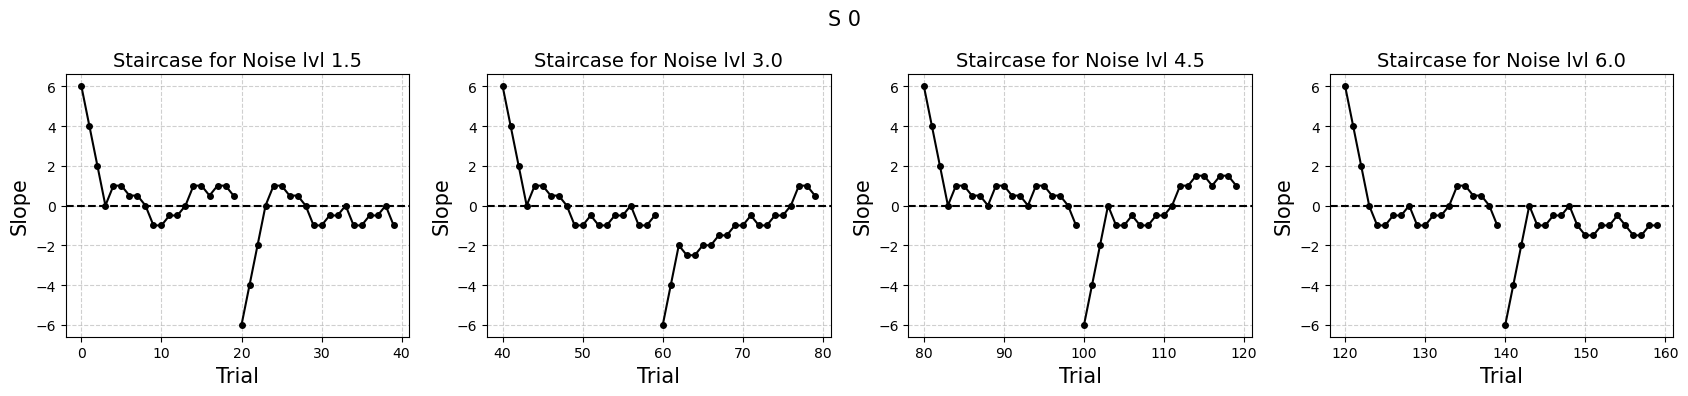

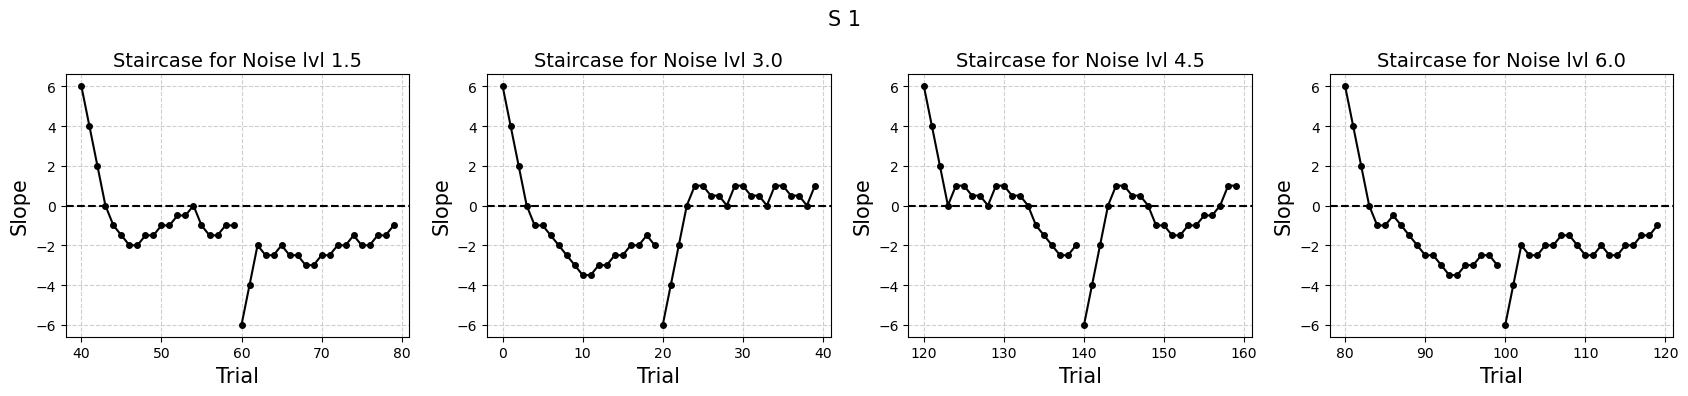

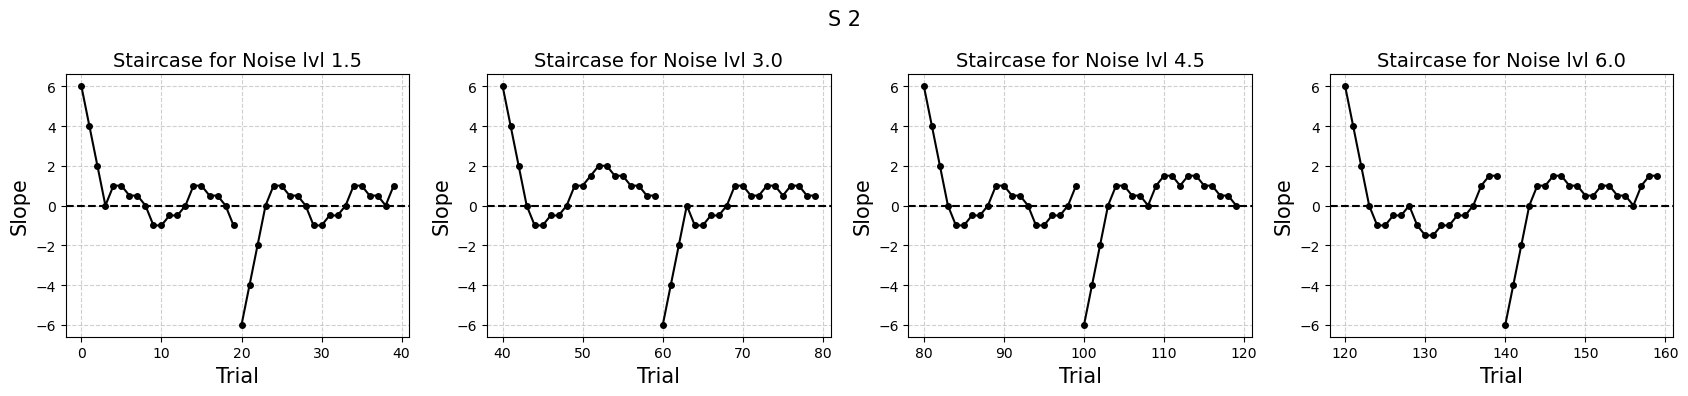

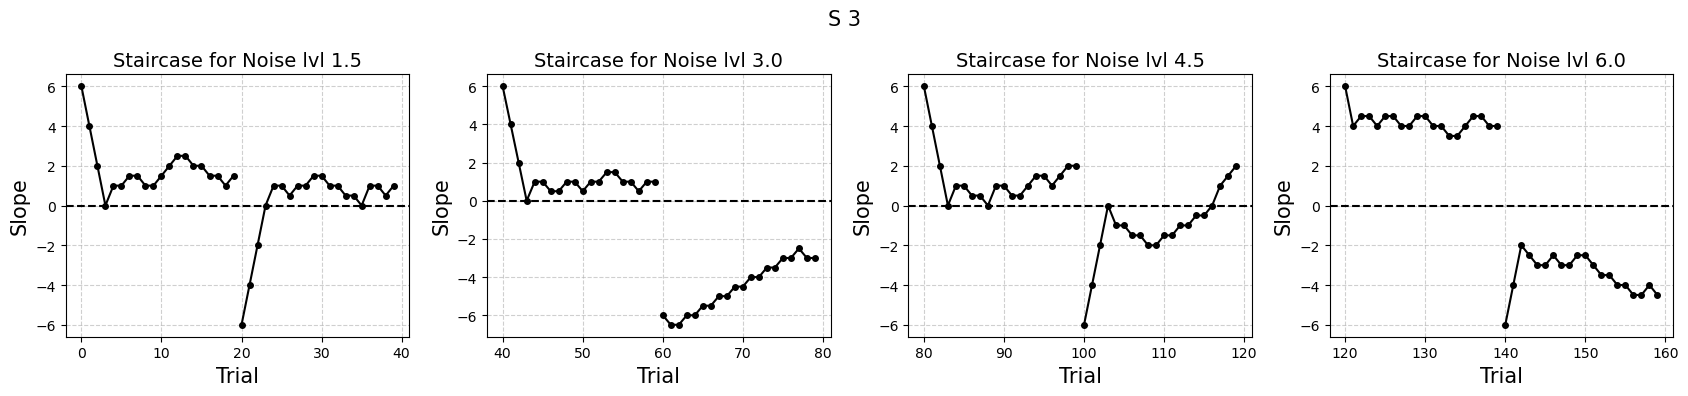

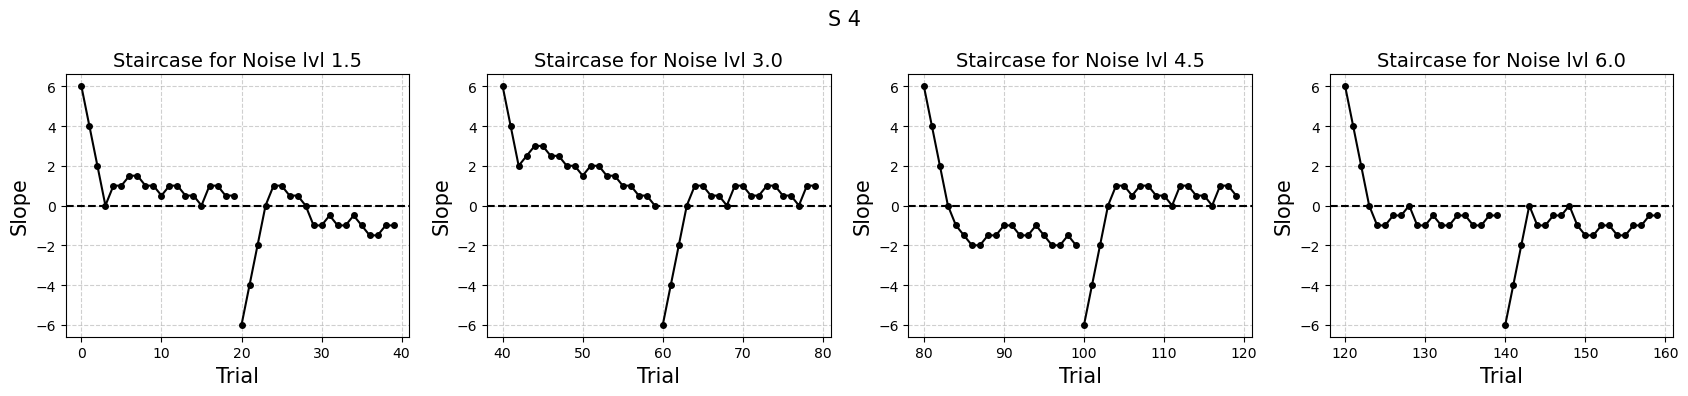

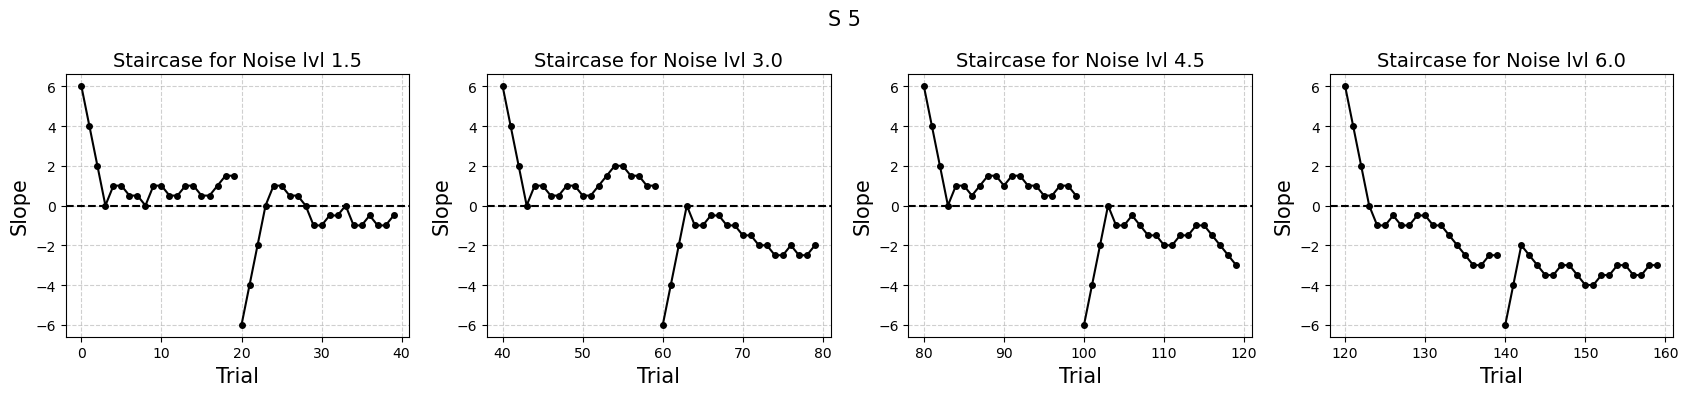

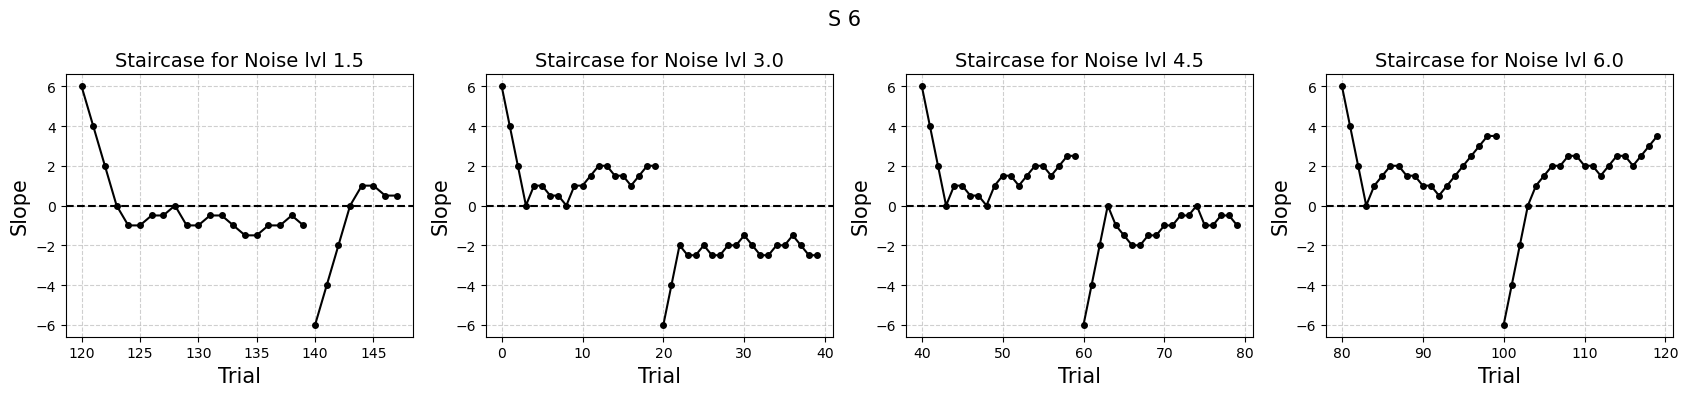

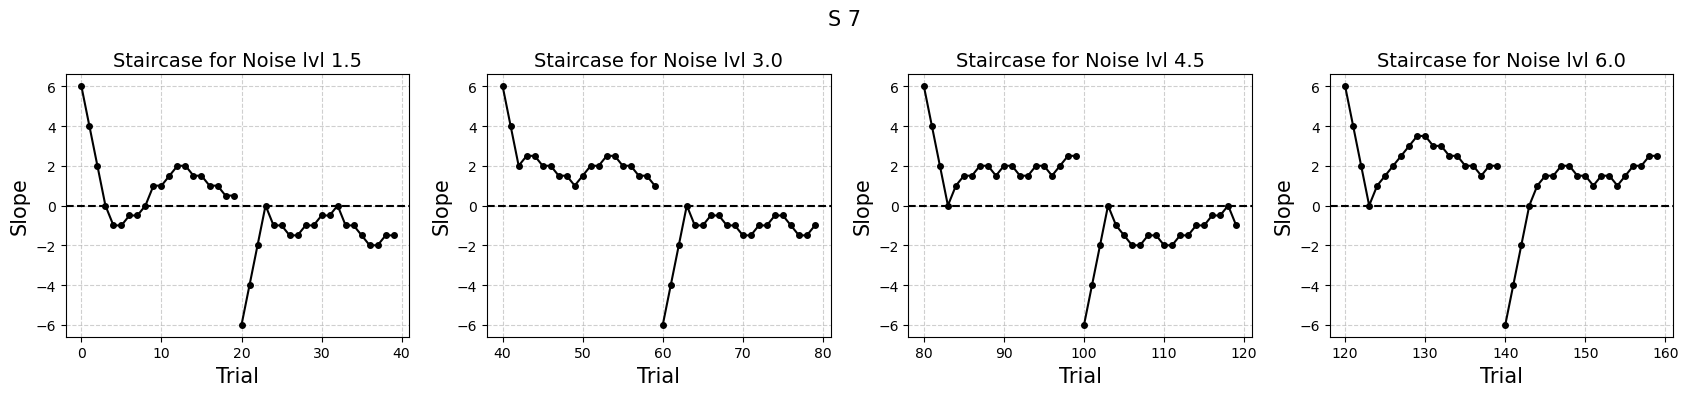

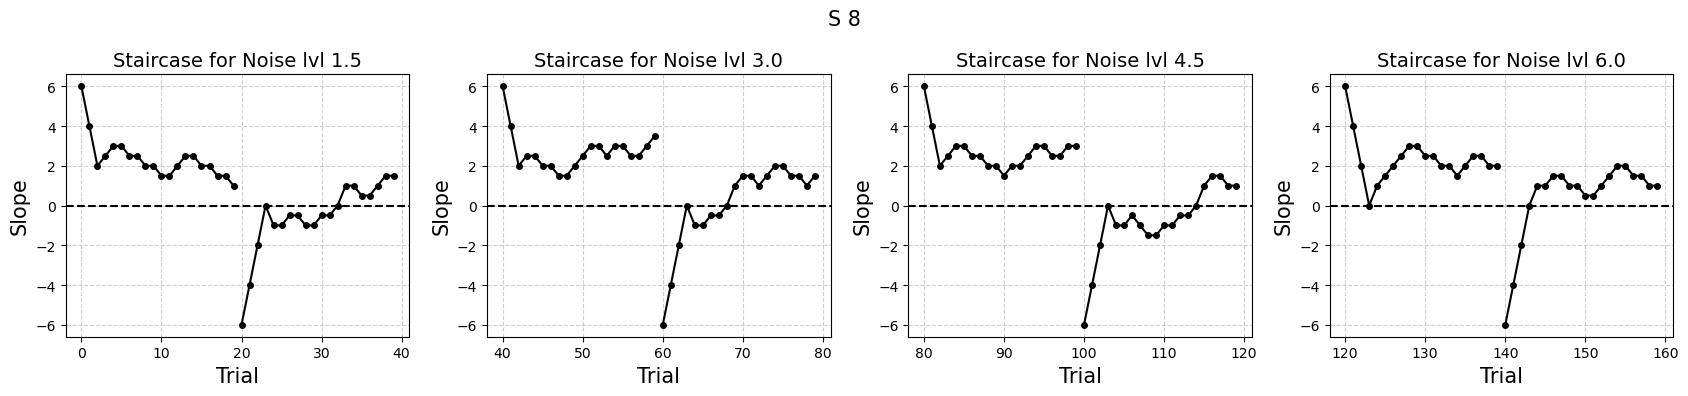

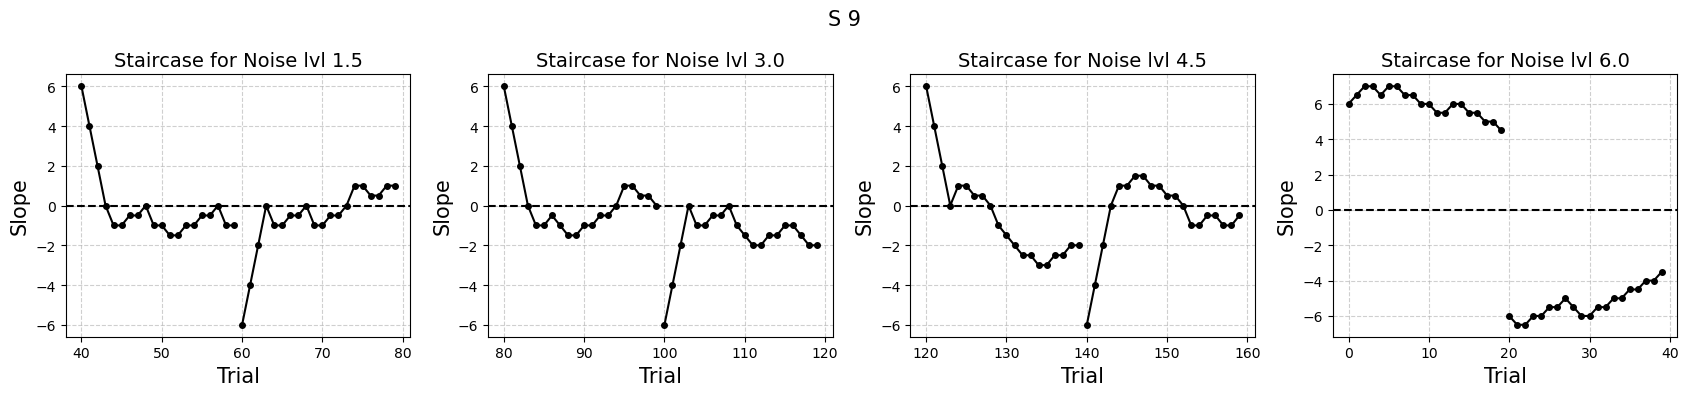

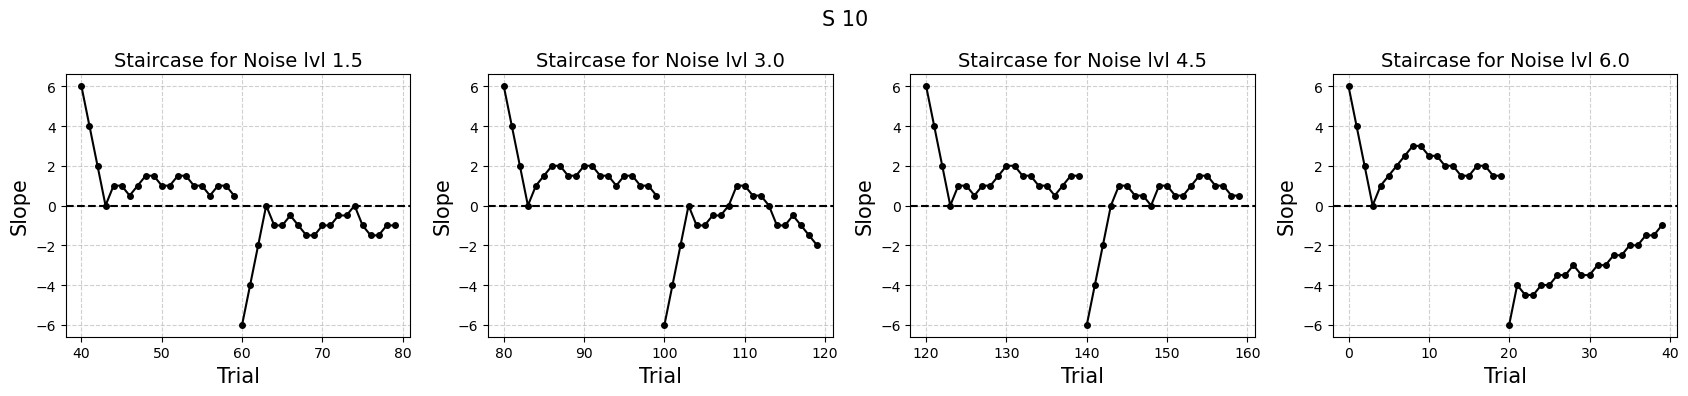

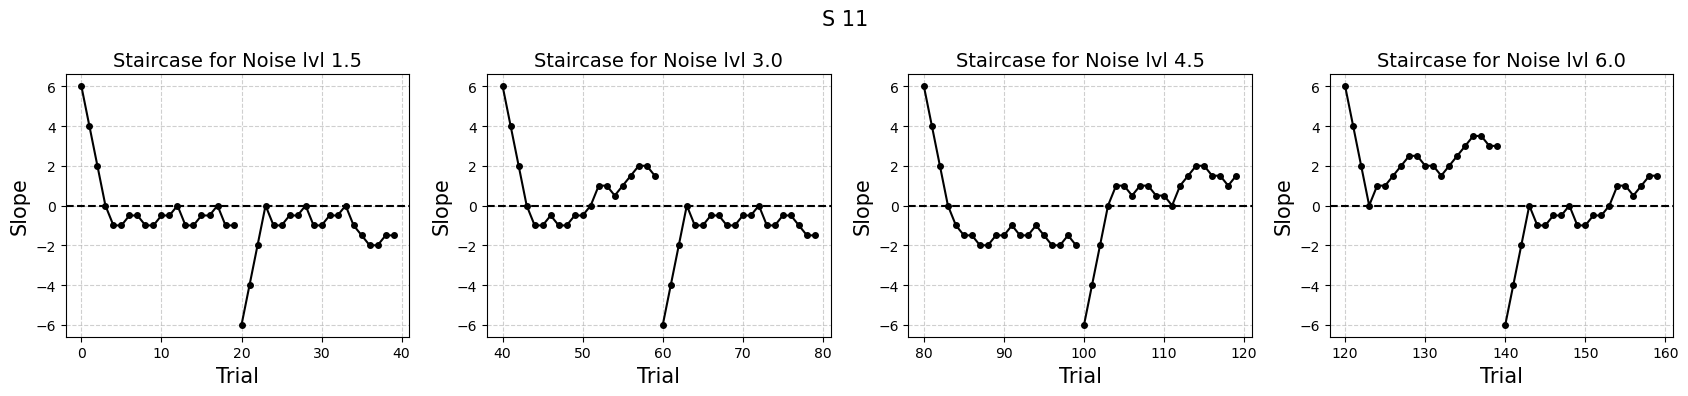

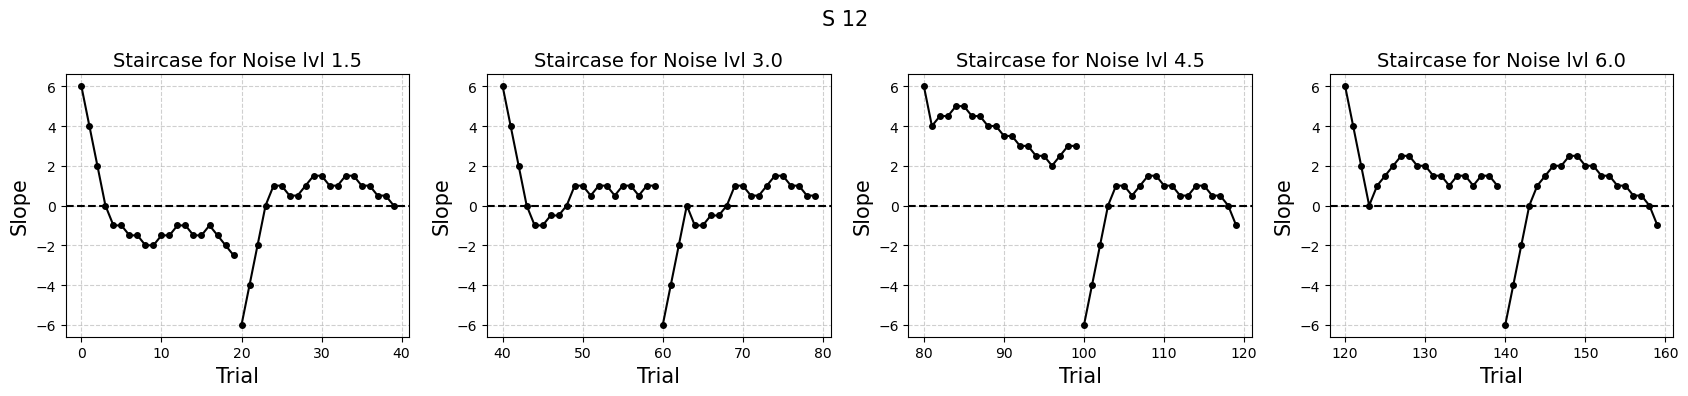

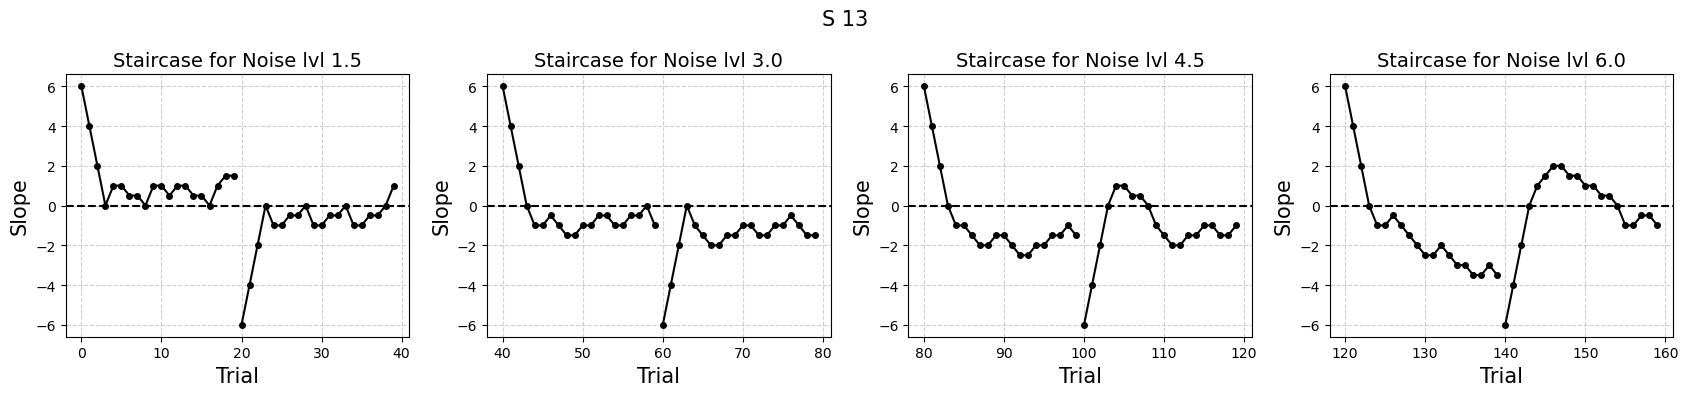

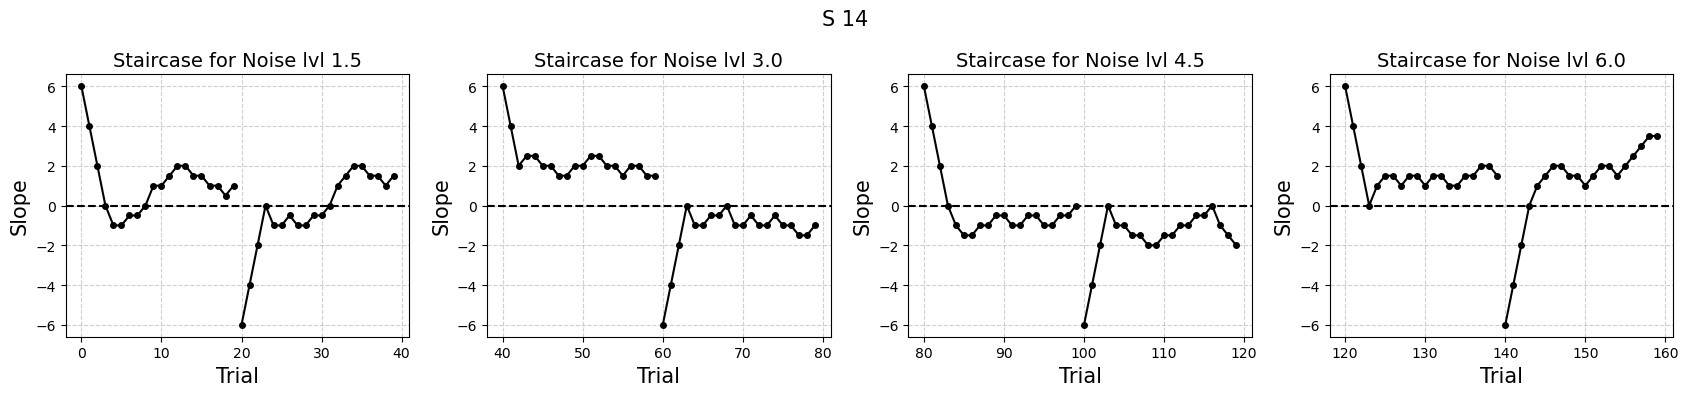

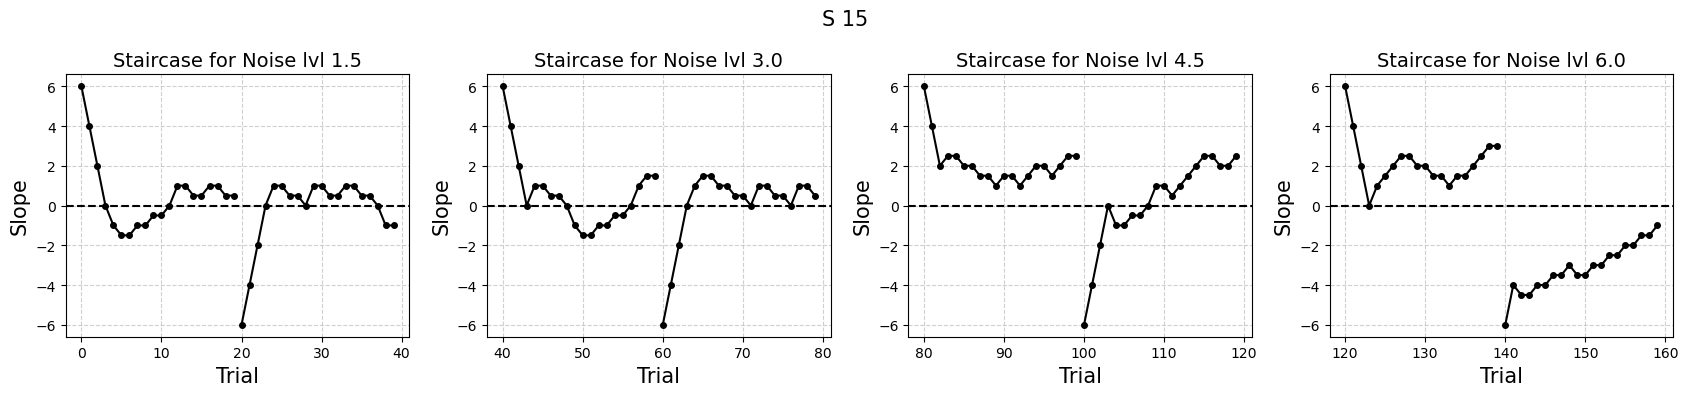

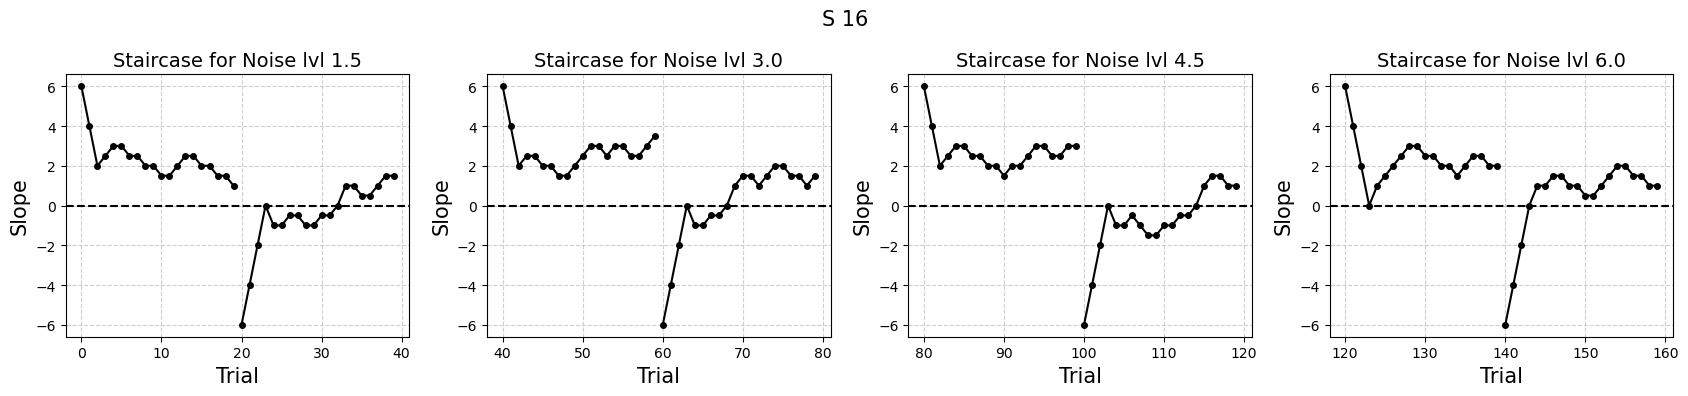

In [8]:
plot_staircase(data_l_clean)

In [8]:
def plot_simple_curve(data_list):
    for elem in range(len(data_list)):
        data= data_list[elem]
        # group by (noise_lvl) and distance from center (slope)
        grouped = data.groupby(['noise_lvl', 'slope'])['prop_left'].mean().reset_index()
        unique_noise_levels = grouped['noise_lvl'].unique()
        fig =plt.figure(figsize=(7, 5))
        for noise in unique_noise_levels:
            subset = grouped[grouped['noise_lvl'] == noise]
            slope_values = subset['slope']
            prop_left_values = subset['prop_left']
            plt.plot(slope_values, prop_left_values, marker='o', label=f'Noise lvl {noise}')
#             plt.scatter(slope_values, prop_left_values, label=f'Noise lvl {noise}', marker='o', s=30)
        plt.xlabel(' Distance from center')
        plt.ylabel('Proportion of "left" responses')
        plt.title(f'Psychometric Curve subj {elem}')
        plt.legend(title='Noise lvl')
        plt.grid(True)

        # plt.scatter(data['slope'], data['prop_left'], color='b', label='real', marker='x', s=30)
        plt.xticks(range(-10, 11, 1))
        plt.yticks(np.arange(0, 1, 0.1))

        plt.legend()
        plt.show()

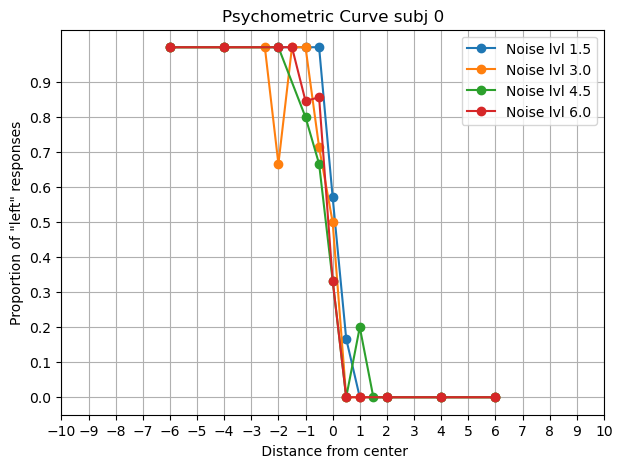

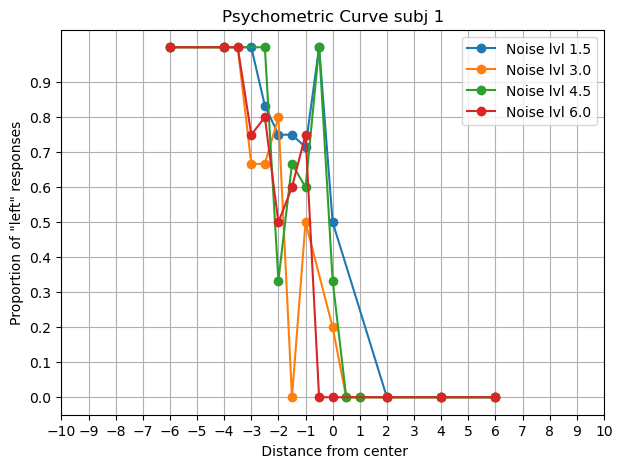

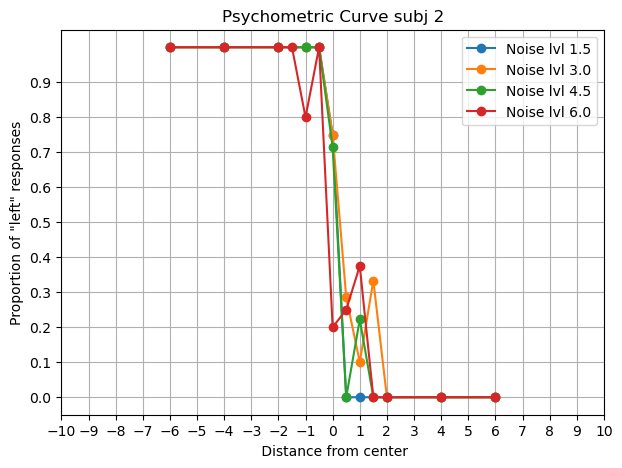

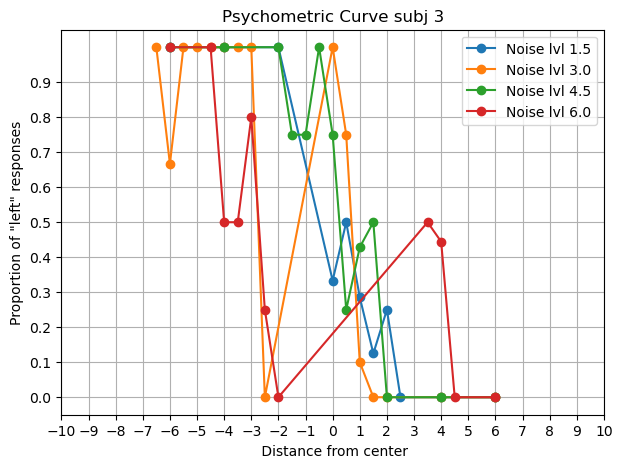

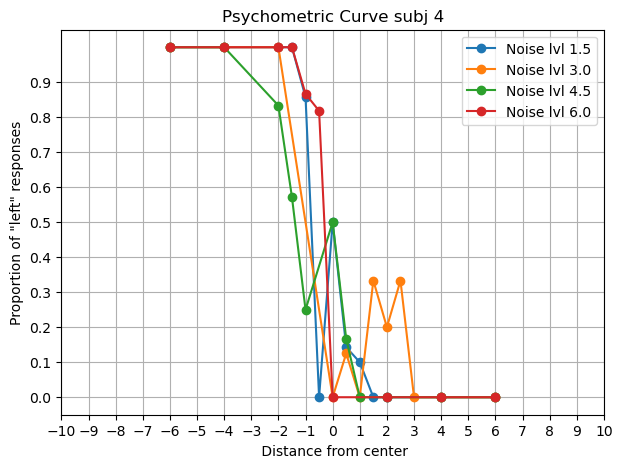

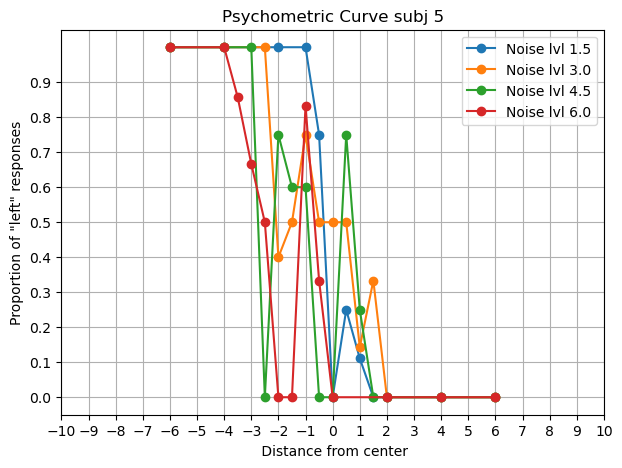

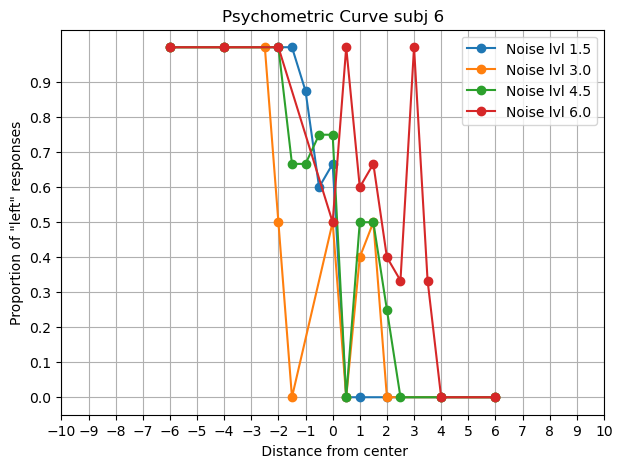

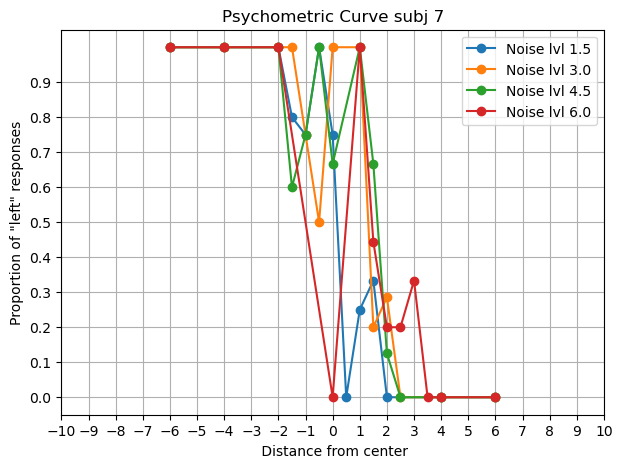

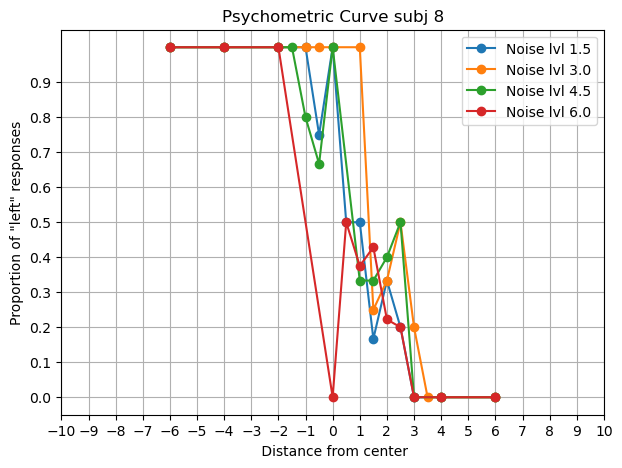

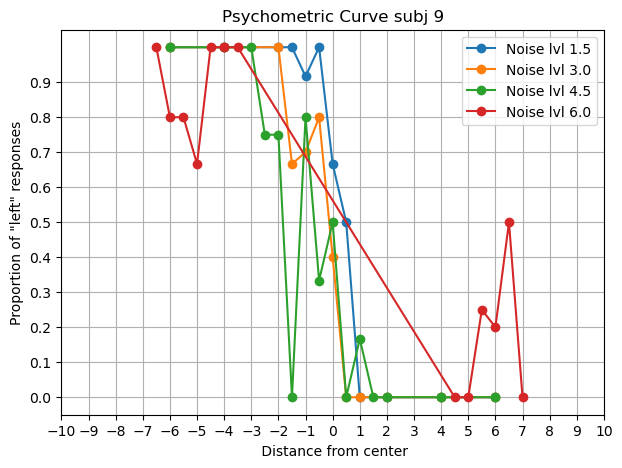

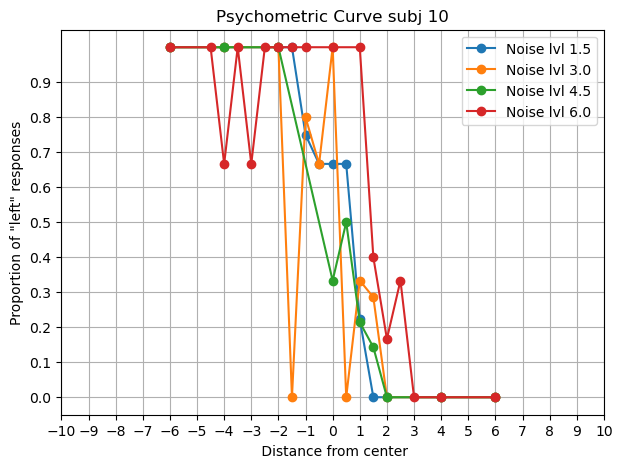

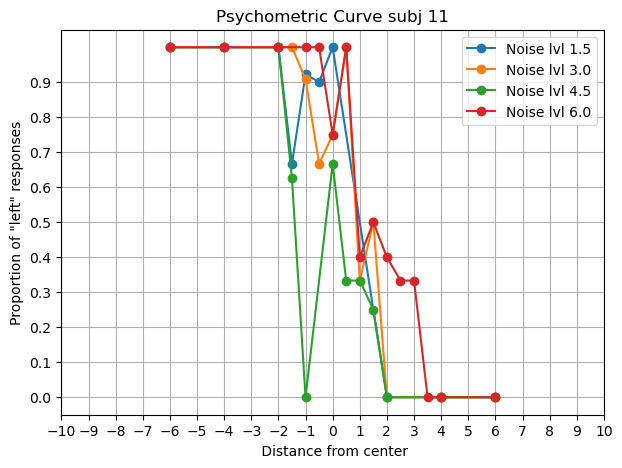

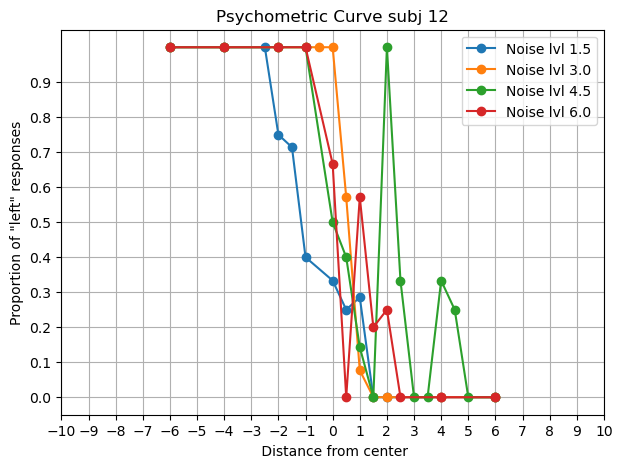

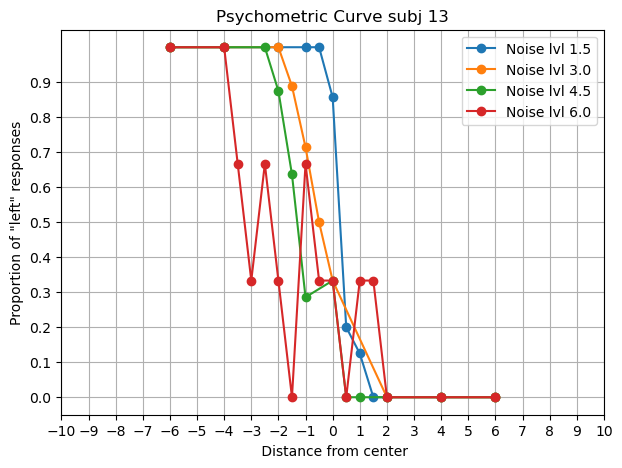

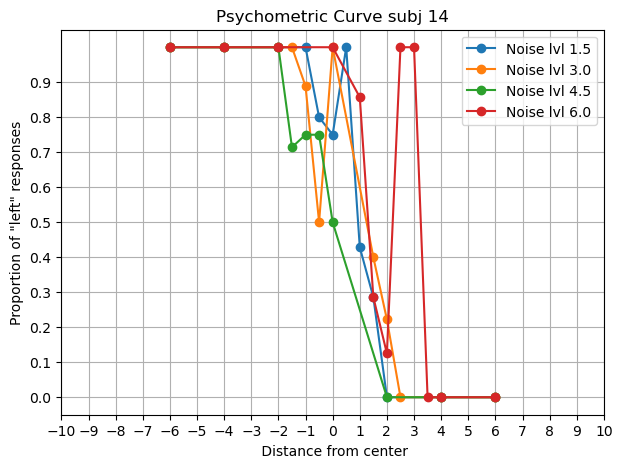

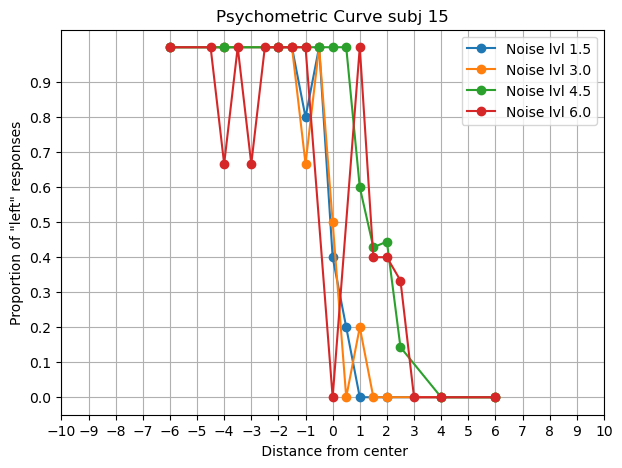

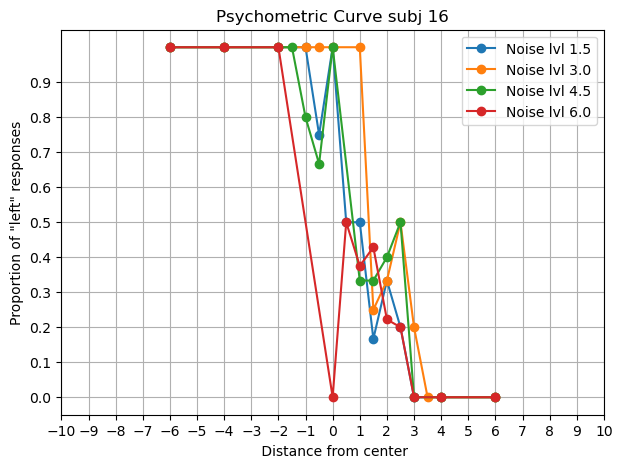

In [10]:
plot_simple_curve(data_l_clean)

In [89]:
def plot_staircase_with_reversals(data, step_column, trial_column, reversal_column, acc_column):
    plt.figure(figsize=(14, 7))
    fontsize = 25
  
    #plt.plot(
    #    data[trial_column], 
    #   data[step_column], 
    #    'k-', linewidth=2
    #)

    plt.plot(
        data[data[trial_column] <= 19][trial_column], 
        data[data[trial_column] <= 19][step_column], 
        'k-', linewidth=2, label="Left side trials"
    )

    # Trials after 20: dashed line
    plt.plot(
        data[data[trial_column] >= 20][trial_column], 
        data[data[trial_column] >= 20][step_column], 
        'k--', linewidth=2, label="Right side trials"
    )
    
    plt.scatter(
        data[data[acc_column] == 1][trial_column],
        data[data[acc_column] == 1][step_column],
        facecolors='k', edgecolors='k', s=200, label='Side detected', marker='s', linewidths=2
    )
    plt.scatter(
        data[data[acc_column] == 0][trial_column],
        data[data[acc_column] == 0][step_column],
        facecolors='w', edgecolors='k', s=200, label='Side not detected', marker='s', linewidths=2
    )

    reversal_points = data[data[reversal_column]]
    plt.scatter(
        reversal_points[trial_column], 
        reversal_points[step_column], 
        facecolors='none', 
        edgecolors='k', 
        s=700, 
        label='Reversal Points', 
        marker='o', linewidths=2
    )

    #plt.axhline(y=0, color='k', linestyle='--', alpha=0.7)
    plt.axhline(y=0.7, color='b', linestyle='--', alpha=0.7,label='Threshold')
    plt.xlabel("Trial Number", fontsize=fontsize)
    plt.ylabel("Distance from screen center (deg)", fontsize=fontsize)
    plt.tick_params(axis='both', which='major', labelsize=fontsize, length=10, width=2)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc='best', fontsize=fontsize - 5)
    plt.tight_layout()
    plt.show()


In [81]:
# Works
data = data_l_clean[2][data_l_clean[2]['noise_lvl'] == 3.0]
data = data_l_clean[1][data_l_clean[1]['noise_lvl'] == 4.5]
data['slope_abs']= data['slope'].abs()
# Создаём список точек разворота
reversals = []
is_reversal = []
correct_responses_after_error = 0  # Счетчик правильных ответов после ошибки
last_response = None  # Последний ответ участника
first_reversal_skipped = False  # Флаг для пропуска первой разворотной точки

for _, row in data.iterrows():
    current_response = row['acc']  # Текущий ответ (1 - правильный, 0 - неправильный)

    # Если ответ правильный
    if current_response == 1:
        correct_responses_after_error += 1
        if correct_responses_after_error == 2:  # Второй правильный ответ после ошибки
            if not first_reversal_skipped:  # Пропускаем первую разворотную точку
                first_reversal_skipped = True
                is_reversal.append(False)
            else:
                reversals.append(row['slope'])
                is_reversal.append(True)
        else:
            is_reversal.append(False)
    else:  # Если ответ неправильный
        if correct_responses_after_error > 0:  # Ошибка после хотя бы одного правильного ответа
            if not first_reversal_skipped:  # Пропускаем первую разворотную точку
                first_reversal_skipped = True
                is_reversal.append(False)
            else:
                reversals.append(row['slope'])
                is_reversal.append(True)
        else:
            is_reversal.append(False)
        correct_responses_after_error = 0  

    last_response = current_response

    if row['num_trial'] == 19:
        last_response = None
        correct_responses_after_error = 0
        first_reversal_skipped = False

data['is_reversal'] = is_reversal



C:\Users\Oleg\AppData\Local\Temp\ipykernel_3360\2043182815.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['slope_abs']= data['slope'].abs()
C:\Users\Oleg\AppData\Local\Temp\ipykernel_3360\2043182815.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['is_reversal'] = is_reversal


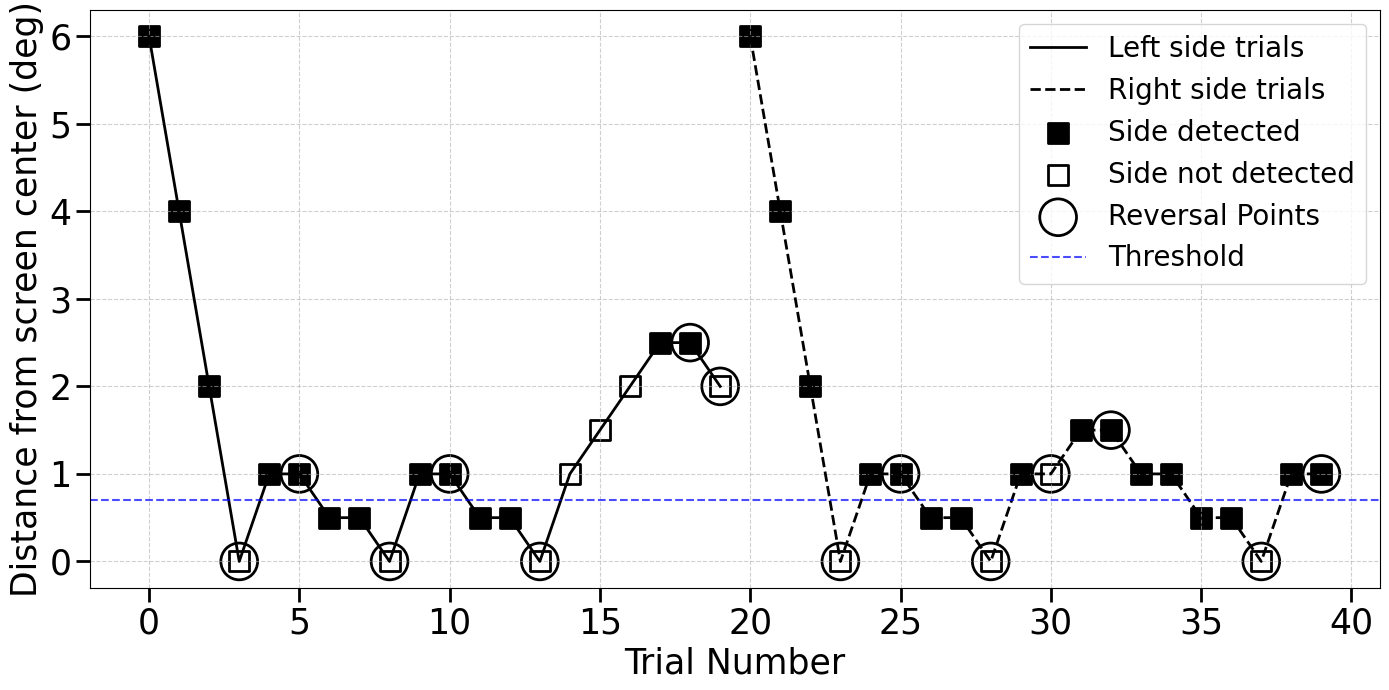

In [90]:
plot_staircase_with_reversals(
    data, 
    step_column='slope_abs', 
    trial_column='num_trial', 
    reversal_column='is_reversal', 
    acc_column='acc'
)

In [86]:
def extract_reversals(data, step_column, response_column):
    
    reversals = []
    is_reversal = []
    correct_responses_after_error = 0  
    last_response = None 
    first_reversal_skipped = False  
    
    for _, row in data.iterrows():
        current_response = row['acc'] 

        if current_response == 1:
            correct_responses_after_error += 1
            if correct_responses_after_error == 2:  
                if not first_reversal_skipped:  
                    first_reversal_skipped = True
                    is_reversal.append(False)
                else:
                    reversals.append(row['slope'])
                    is_reversal.append(True)
            else:
                is_reversal.append(False)
        else: 
            if correct_responses_after_error > 0:  
                if not first_reversal_skipped:  
                    first_reversal_skipped = True
                    is_reversal.append(False)
                else:
                    reversals.append(row['slope'])
                    is_reversal.append(True)
            else:
                is_reversal.append(False)
            correct_responses_after_error = 0  
    
        last_response = current_response
    
        if row['num_trial'] == 19:
            last_response = None
            correct_responses_after_error = 0
            first_reversal_skipped = False
    return reversals

In [ ]:
def extract_reversals(data, step_column, response_column):
    reversals = []
    is_reversal= []
    last_response = None
    count = 0
    for _, row in data.iterrows():
        current_response = row['acc']
        if current_response == 1:
            count += 1
        #print(f' {_},last {last_response} cur {current_response}')
        if last_response is not None and current_response != last_response:
            reversals.append(row['slope'])
            is_reversal.append(True)
        else:
            is_reversal.append(False)
        last_response = current_response
        if row['num_trial'] ==19:
            last_response = None
    return reversals

In [28]:
### IT IS WORK !!!!!!!!!!!!!!!!! ############ 
def extract_reversals(data, step_column, response_column):
    
    reversals = []
    is_reversal = []
    correct_responses_after_error = 0  
    last_response = None 
    first_reversal_skipped = False  
    
    for _, row in data.iterrows():
        current_response = row['acc'] 

        if current_response == 1:
            correct_responses_after_error += 1
            if correct_responses_after_error == 2:  
                if not first_reversal_skipped:  
                    first_reversal_skipped = True
                    is_reversal.append(False)
                else:
                    reversals.append(row['slope'])
                    is_reversal.append(True)
            else:
                is_reversal.append(False)
        else: 
            if correct_responses_after_error > 0:  
                if not first_reversal_skipped:  
                    first_reversal_skipped = True
                    is_reversal.append(False)
                else:
                    reversals.append(row['slope'])
                    is_reversal.append(True)
            else:
                is_reversal.append(False)
            correct_responses_after_error = 0  
    
        last_response = current_response
    
        if row['num_trial'] == 19:
            last_response = None
            correct_responses_after_error = 0
            first_reversal_skipped = False
    return reversals

def compute_jnd(data, step_column, response_column, noise_column):
    results = []

    for noise_lvl, group_noise in data.groupby(noise_column):
        reversals = extract_reversals(group_noise, step_column, response_column)
        reversals_abs = [abs(c) for c in reversals]
        if len(reversals) > 1:
            #pse = np.mean(reversals_abs)  # PSE
            pse = np.mean(reversals_abs[1:]) 
            #jnd = (np.max(reversals) - np.min(reversals)) / 2  # JND
            jnd = np.std(reversals)
            q75, q25 = np.percentile(reversals_abs, [75, 25])
            jnd_iqr = (q75 - q25) / 2
        else:
            pse = None
            jnd = None
            jnd_iqr = None
        
        results.append({
            'Noise Level': noise_lvl,
            'PSE': pse,
            'JND': jnd,
            'JND_iqr': jnd_iqr
        })

    return pd.DataFrame(results)


final_results = []

for subject_id, subject_data in enumerate(data_l_clean):
    subject_jnd = compute_jnd(
        data=subject_data,
        step_column='slope',
        #response_column='acc',
        response_column='prop_left',
        noise_column='noise_lvl'
    )
    subject_jnd['Subject'] = f"{subject_id}"
    final_results.append(subject_jnd)

final_jnd_df = pd.concat(final_results, ignore_index=True)

In [33]:
final_jnd_df_pivot = final_jnd_df.pivot_table(index='Subject', columns='Noise Level', values='PSE').reset_index()

In [34]:
final_jnd_df_pivot.to_csv('threshold_new_mean_acc_full_last.csv', index = False)